## Ariane 5 Vulcain Engine

Some key points should be noted on the Vulcain engine:
- The combustion chamber is cooled seperately to the nozzle extension
- The nozzle extension is cooled by dump cooling
- The combustion chamber is regeneratively cooled

Data on predicted coolant temperatures and heat transfer rates for the Vulcain engine are available online, from page 10 of the following source:
- http://servidor.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf

Experimental data at the endpoints are also shown in the document above, and reinforce the predicted data.

This document aims to compare Bamboo's predictions for the Vulcain's heat transfer rates with the predictions in the document above.

Addition data on the Vulcain (including thermal conductivity of the walls) was found from:
- https://www.researchgate.net/figure/Throat-of-the-combustion-chamber-modeling-characteristi-c-failure-and-optimization_fig2_224789875

In [1]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import thermo
import matplotlib.pyplot as plt
import numpy as np

Using a an online graph image-to-data converter, we can obtain the raw data.

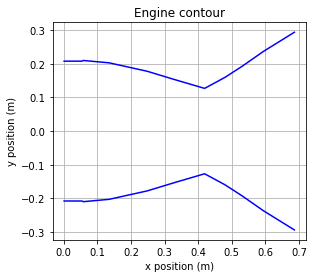

In [2]:
#'x' key corresponds to position in metres (0 = beginning of chamber). 'y' corresponds to the data.

#Coolant temperature in K 
coolant_temperature_data = {"x":[-0.002,0.012,0.029,0.045,0.197,0.26,0.32,0.37,0.424,0.485,0.529,0.592,0.648,0.687],
                            "y":[92.203,90.169,88.136,86.441,68.983,61.186,53.39,45.763,38.814,30.339,24.407,17.119,11.186,6.78]}

#Heat transfer rate in W/cm^2
heat_transfer_rate = {"x":[-0.003,0.022,0.036,0.049,0.062,0.086,0.113,0.129,0.152,0.171,0.192,0.205,0.221,0.244,0.27,0.294,0.31,0.327,0.342,0.36,0.368,0.382,0.398,0.421,0.439,0.447,0.452,0.465,0.477,0.49,0.5,0.512,0.524,0.534,0.548,0.564,0.58,0.596,0.612,0.631,0.647,0.664,0.688],
                      "y":[3374.422,3577.812,3697.997,3744.222,3762.712,3716.487,3661.017,3661.017,3670.262,3688.752,3707.242,3771.957,3818.182,3938.367,4114.022,4335.901,4539.291,4816.641,5075.501,5334.361,5574.73,5796.61,5935.285,5861.325,5648.69,5214.176,4983.051,4594.761,4298.921,3827.427,3522.342,3161.787,2930.663,2662.558,2440.678,2191.063,1996.918,1821.263,1710.324,1590.139,1479.199,1386.749,1322.034]}

#Engine contour (m) - up to the beginning of the nozzle extension.
engine_contour = {"x":[0.001,0.054,0.058,0.135,0.248,0.327,0.419,0.48,0.531,0.594,0.686],
                  "y":[0.208,0.208,0.21,0.203,0.178,0.154,0.127,0.16,0.193,0.237,0.294]}

#Plot the engine contour
fig, axs = plt.subplots()
axs.plot(engine_contour["x"], engine_contour["y"], color = 'blue')
axs.plot(engine_contour["x"], -np.array(engine_contour["y"]), color = 'blue')
axs.set_aspect('equal')
axs.grid()
plt.title("Engine contour")
axs.set_xlabel("x position (m)")
axs.set_ylabel("y position (m)")
plt.show()

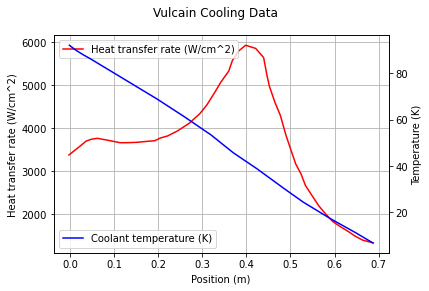

In [3]:
#Plot the data
fig, ax1 = plt.subplots()
fig.suptitle("Vulcain Cooling Data")

#Plot heat transfer rates
ax1.plot(heat_transfer_rate["x"], heat_transfer_rate["y"], label="Heat transfer rate (W/cm^2)", color="red")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()
ax1.legend(loc = "upper left")

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       #Second axes that shares the same x-axis as ax1
ax2.plot(coolant_temperature_data["x"], coolant_temperature_data["y"], label="Coolant temperature (K)", color="blue")
ax2.set_ylabel("Temperature (K)")
ax2.legend(loc = 'lower left')

plt.show()

### Bamboo engine model

The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [4]:
thrust = 1007.7e3   #N - in vacuum
isp = 439           #seconds - in vacuum
pc = 100e5
OF_ratio = 5.6      #by mass I think?

mdot = thrust/(isp*9.81)

#Use pypropep to get chamber temperature
ppp.init()
e = ppp.Equilibrium()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

#Add propellants by mass fractions
e.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

#Adiabatic combustion using chamber pressure                      
e.set_state(P = pc/1e5, type='HP')     

#Get results
gamma = e.properties.Isex   #pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*e.properties.Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = e.properties.T

print(f"\nTotal mass flow rate = {mdot} kg/s")
print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(e.composition)

Loaded 1921 thermo species
Loaded 1031 propellants

Total mass flow rate = 233.99023357226946 kg/s
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
{'H': 0.028801796474919292, 'HO2': 1.7031381331243065e-05, 'H2': 0.2896925690851782, 'H2O': 0.6493671319106238, 'H2O2': 7.94208687267654e-06, 'O': 0.0016810512414820072, 'OH': 0.028980423622929952, 'O2': 0.0014520541971763574, 'O3': 0.0}


In [5]:
#Engine object
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle(At = bam.get_throat_area(perfect_gas, chamber_conditions), 
                    Ae = np.pi*0.294**2, type = "rao")

engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

In [6]:
#Engine geometry - estimated by looking at the contour diagram. Thickness is a complete guess.
engine.add_geometry(chamber_length = 0.2, 
                    chamber_area = 0.2, 
                    inner_wall_thickness = 1e-2)


In [7]:
'''Transport properties'''
thermo_gas = thermo.mixture.Mixture(['hydrogen', 'water', 'oxygen'], zs = [0.28969, 0.649367, 0.001452]) #maybe should be ws not zs? 

#Setup the exhaust gas transport properties
def Pr_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.Prg

def mu_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.mug

def k_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.kg

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)
'''
gas_transport = bam.cooling.TransportProperties(type = "constants", 
                                                mu = 7.5e-5, 
                                                k =  0.20, 
                                                Pr = 0.62)
'''
#Set up the coolant transport properties
#fixed_T = 80

def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 
   
    
coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)
'''
coolant_transport = bam.cooling.TransportProperties(type = "constants", 
                                                    mu = 2.4e-3, 
                                                    k = 0.14, 
                                                    cp = 3000, 
                                                    rho = 71,
                                                    Pr = 7.56)
'''
#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

In [8]:
#Wall material
vulcain_wall = bam.cooling.Material(E = float("NaN"), 
                                    sigma_y = float("NaN"), 
                                    poisson = float("NaN"), 
                                    alpha = float("NaN"), 
                                    k = 310, 
                                    c = float("NaN"))

In [9]:
engine.add_cooling_jacket(inner_wall = vulcain_wall, 
                          inlet_T = 12,                          #CoolProp seems to have trouble with H2 below 12K 
                          inlet_p0 = 150e5, 
                          coolant_transport = coolant_transport, 
                          mdot_coolant = mdot/OF_ratio, 
                          configuration = "vertical", 
                          channel_height = 5e-3,
                          blockage_ratio = 0.4,
                          number_of_ribs = 50)

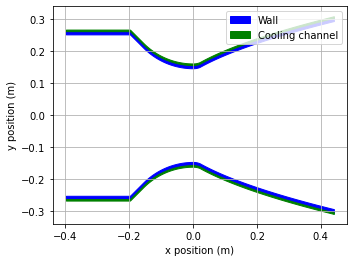

In [10]:
engine.plot_geometry()

In [11]:
#Run simulation
bamboo_data = engine.steady_heating_analysis(to_json = False, h_gas_model = 'bartz-sigma', h_coolant_model = 'sieder-tate')

Coolant exit temperature: 86.08582796852399 K


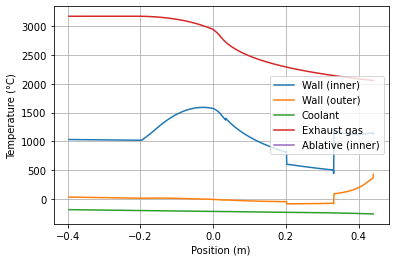

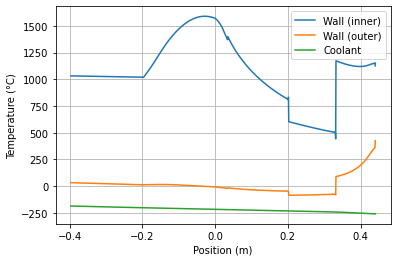

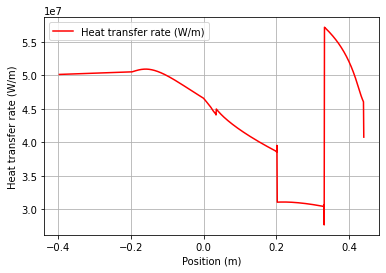

In [12]:
#Show plots
bam.plot.plot_temperatures(bamboo_data, show_gas = True, show_ablative = True)
bam.plot.plot_temperatures(bamboo_data, show_gas = False, show_ablative = False)
bam.plot.plot_qdot(bamboo_data, show_gas = False, show_ablative = False)

print(f"Coolant exit temperature: {bamboo_data['T_coolant'][-1]} K")

plt.show()

In [13]:
#Convert heat transfer rates to per unit area - divide by the circumference
q_per_area = np.zeros(len(bamboo_data['q_dot']))
for i in range(len(q_per_area)):
    q_per_area[i] = bamboo_data['q_dot'][i]/(2*np.pi*engine.y(bamboo_data["x"][i]))


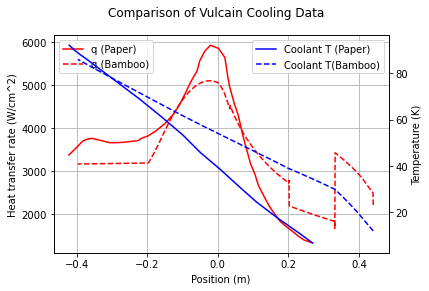

In [14]:
#Compare results with data from paper
fig, ax1 = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data")

#Need to shift the x axes of the two so they align
throat_pos = 0.419

#Plot heat transfer rates
ax1.plot(np.array(heat_transfer_rate["x"]) - throat_pos, heat_transfer_rate["y"], label="q (Paper)", color="red")
ax1.plot(bamboo_data["x"], q_per_area*(1e-2)**2, label="q (Bamboo)", color="red", linestyle = "--")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()
ax1.legend(loc = "upper left")

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       
ax2.plot(np.array(coolant_temperature_data["x"]) - throat_pos, coolant_temperature_data["y"], label="Coolant T (Paper)", color="blue")
ax2.plot(bamboo_data["x"], bamboo_data["T_coolant"], label="Coolant T(Bamboo)", color="blue", linestyle = "--")

ax2.set_ylabel("Temperature (K)")
ax2.legend(loc = 'upper right')

plt.show()

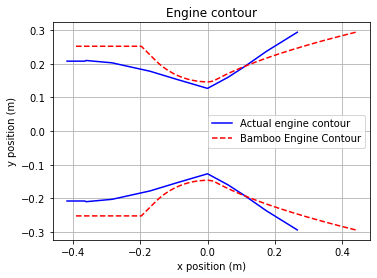

In [15]:
#Compare engine contours
bamboo_ys = np.zeros(len(bamboo_data["x"]))
for i in range(len(bamboo_ys)):
    bamboo_ys[i] = engine.y(bamboo_data["x"][i])

#Plot
fig, axs = plt.subplots()

axs.plot(np.array(engine_contour["x"]) - throat_pos , engine_contour["y"], color = 'blue', label = "Actual engine contour")
axs.plot(np.array(engine_contour["x"]) - throat_pos, -np.array(engine_contour["y"]), color = 'blue')

axs.plot(bamboo_data["x"], bamboo_ys, color = 'red', label = "Bamboo Engine Contour", linestyle = "--")
axs.plot(bamboo_data["x"], -bamboo_ys, color = 'red', linestyle = "--")

axs.set_aspect('equal')
axs.grid()
axs.legend()
plt.title("Engine contour")
axs.set_xlabel("x position (m)")
axs.set_ylabel("y position (m)")
plt.show()
